In [81]:
!mkdir food_dataset
!./google-cloud-sdk/bin/gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead" ./food_dataset
!./google-cloud-sdk/bin/gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/metadata" ./food_dataset
!./google-cloud-sdk/bin/gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids" ./food_dataset

mkdir: cannot create directory ‘food_dataset’: File exists
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/depth_color.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/depth_raw.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/rgb.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556573514/depth_raw.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556573514/depth_color.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556575014/depth_color.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556575014/depth_raw.png...
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556575083/depth_color.png...
Copying gs://nutrition5k_dataset/nu

In [1]:
# prompt: create a dataloader for the nutrition5k_dataset. Filenames are located inside the food_dataset/dish_ids/splits/rgb_train_ids.txt for training and  food_dataset/dish_ids/splits/rgb_test_ids.txt for testing.
# for each filename inside the text, the file is located in:  food_dataset/realsense_overhead/<FILENAME>/rgb.png. 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import csv

class Nutrition5kDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform

        if split == 'train':
            split_file = os.path.join(data_dir, 'dish_ids', 'splits', 'rgb_train_ids.txt')
        elif split == 'test':
            split_file = os.path.join(data_dir, 'dish_ids', 'splits', 'rgb_test_ids.txt')
        else:
            raise ValueError("Invalid split. Choose 'train' or 'test'.")

        with open(split_file, 'r') as f:
            self.image_ids = [line.strip() for line in f]
            self.image_ids = [image_id for image_id in self.image_ids if os.path.exists(os.path.join(data_dir, 'realsense_overhead', image_id, 'rgb.png'))]
        
        #self.image_ids = os.listdir(os.path.join(data_dir, 'realsense_overhead'))
        #self.image_ids = [image_id for image_id in self.image_ids if os.path.exists(os.path.join(data_dir, 'realsense_overhead', image_id, 'rgb.png'))]
        print(len(self.image_ids))

    def __len__(self):
        return len(self.image_ids)

    def get_csv_line(self, image_id):
      csv_files = [
          "./food_dataset/metadata/dish_metadata_cafe1.csv",
          "./food_dataset/metadata/dish_metadata_cafe2.csv"
      ]

      for csv_file in csv_files:
          if os.path.exists(csv_file):
              with open(csv_file, 'r', encoding='utf-8') as file:
                  reader = csv.reader(file) 
                  for row in reader:
                      if row and row[0] == image_id:  
                          return row  
      return None  

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.data_dir, 'realsense_overhead', image_id, 'rgb.png')
        
        try:
          image = Image.open(image_path).convert('RGB')
        except FileNotFoundError:
          print(f"Warning: Image file not found at {image_path}. Skipping.")
          # Return a placeholder or handle the error as needed
          return torch.zeros(size=((3, 224, 224))), None

        if self.transform:
            image = self.transform(image)

        return image, ",".join(self.get_csv_line(image_id))
      

# Example Usage
data_dir = './food_dataset'
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=10),
    # transforms.ColorJitter(brightness=0.001)
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=10),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
])

train_dataset = Nutrition5kDataset(data_dir, split='train', transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) # Adjust num_workers as needed


test_dataset = Nutrition5kDataset(data_dir, split='test', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2) # Adjust num_workers as needed


2755
507


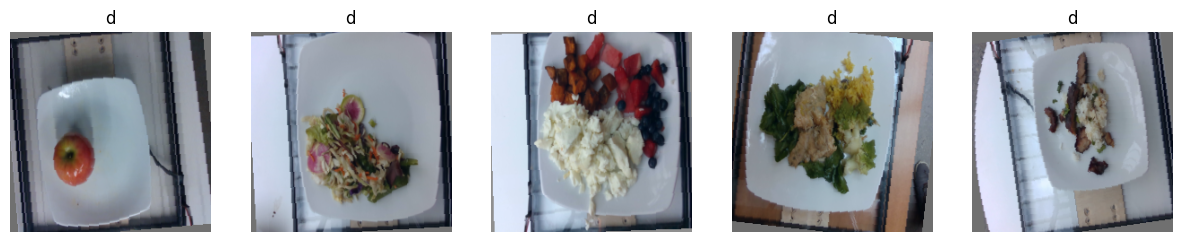

In [2]:
# prompt: create a function to visualize samples from the train_dataset

import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(dataset, num_samples=5):
    """Visualizes samples from the dataset."""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        sample, target = dataset[i]
        if sample is not None:  # Check for potential None values
          # Convert tensor to numpy array and handle different image formats
          if isinstance(sample, torch.Tensor):
              image = sample.permute(1, 2, 0).numpy()
          elif isinstance(sample, np.ndarray):
              image = sample
          else: # Assuming it's PIL image
              image = np.array(sample)

          # Normalize pixel values to the range 0-1 for display
          image = (image - image.min()) / (image.max() - image.min())

          axes[i].imshow(image)
          axes[i].set_title(target[0])
          axes[i].axis('off')
    plt.show()

# Visualize samples from train_dataset
visualize_samples(train_dataset)


In [15]:
import torch
import torch.nn as nn
from torchvision import models

class CustomModel(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomModel, self).__init__()
        # Load a pre-trained MobileNetV2 model (small model)
        self.model = models.mobilenet_v2( pretrained=True)

        # Freeze pre-trained layers
        for param in self.model.parameters():
           param.requires_grad = False

        # Modify the final classification layer
        num_ftrs = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(num_ftrs, 512)
        self.out_linear = nn.Linear(512, num_classes)

    def forward(self, x):
        c = self.model(x)
        c = torch.nn.functional.relu6(c)
        return torch.nn.functional.relu(self.out_linear(c))

# Example usage:
model = CustomModel()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import torch
torch.nn.functional.relu

<function torch.nn.functional.relu(input: torch.Tensor, inplace: bool = False) -> torch.Tensor>

In [4]:
def evaluate():
  model.eval()
  threshold_a = 0.5
  threshold_a = 0.7
  correct_predictions = 0
  total_predictions = 0
  with torch.no_grad():
      for images, labels_raw in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Evaluation"):
          if images is None:
              continue

          images = images.to(device)
          labels = convert_labels(labels_raw)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          total_predictions += labels.size(0)
          correct_predictions += (predicted == labels).sum().item()

  accuracy = 100 * correct_predictions / total_predictions
  print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%")

In [4]:
# carregar pesos no modelo
model.load_state_dict(torch.load("./model_weights_cal_regression.pth"))

<All keys matched successfully>

In [9]:
import torch
import torch.optim as optim
from tqdm import tqdm

In [16]:
# prompt: create a pipeline to train and evalute this model using the datasets, the labels for the images will be processed in a future function called "convert_labels" using the second return element of the dataset.



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomModel().to(device)
def loss_fn(y1, y):
    return torch.nn.functional.mse_loss(torch.sigmoid(y1), y)

def mag_loss(pred, labels):
    batch = pred.shape[0]
    probs = torch.sigmoid(pred)
    diff = probs - labels
    labels = labels.reshape(batch, 555, 2)
    diff = diff.reshape(batch, 555, 2)
    diff = diff.sum(-1)
    diff = torch.where(labels[..., 0]==1., diff*4, diff)
    mse = torch.mean(diff**2)
    return mse

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Example optimizer


def convert_labels(labels):
    # Placeholder: Implement your label conversion logic here.
    # This will take the output from get_csv_line() and convert it to numerical labels.
    # Example: Convert string labels to numerical IDs.
    targets = torch.zeros(len(labels), 5).to(device)
    for i, label in enumerate(labels):
        label = label.split(",")
        # ... your conversion logic ...
        #print(label)
        dish_id, total_calories, total_mass, total_fat, total_carb, total_protein = label[:6]
        ingrs = label[6:]
        for j in range(len(ingrs)//7):
          k = j*7
          #print(ingrs[k:k+7])
          ingr_id = int(ingrs[k].replace("ingr_", "")) - 1
          ingr_name = ingrs[k+1]
          ingr_mass = ingrs[k+2]

          # relative_mass = float(ingr_mass) / float(total_mass)

        #   targets[i, ingr_id*2] = 1.
        #   targets[i, ingr_id*2+1] = relative_mass

          targets[i, 0] = float(total_calories)
          targets[i, 1] = float(total_mass)
          targets[i, 2] = float(total_fat)
          targets[i, 3] = float(total_carb)
          targets[i, 4] = float(total_protein)

    return targets/torch.tensor([400, 200, 10, 10, 5.]).to(device)

num_epochs = 10  # Set the number of epochs

def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels_raw in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Skip if images is None (due to missing image files)
            if images is None or not torch.any(images):
                continue

            images = images.to(device)
            labels = convert_labels(labels_raw)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

        # Evaluation loop


    print("Training finished.")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
train(num_epochs)

Epoch 1/10 - Training: 100%|██████████| 87/87 [01:06<00:00,  1.30it/s]


Epoch [1/10], Training Loss: 3.5871


Epoch 2/10 - Training: 100%|██████████| 87/87 [01:06<00:00,  1.31it/s]


Epoch [2/10], Training Loss: 2.9438


Epoch 3/10 - Training: 100%|██████████| 87/87 [01:04<00:00,  1.35it/s]


Epoch [3/10], Training Loss: 2.8289


Epoch 4/10 - Training: 100%|██████████| 87/87 [01:07<00:00,  1.30it/s]


Epoch [4/10], Training Loss: 2.6479


Epoch 5/10 - Training: 100%|██████████| 87/87 [01:06<00:00,  1.30it/s]


Epoch [5/10], Training Loss: 2.6250


Epoch 6/10 - Training: 100%|██████████| 87/87 [01:06<00:00,  1.31it/s]


Epoch [6/10], Training Loss: 2.7093


Epoch 7/10 - Training: 100%|██████████| 87/87 [00:55<00:00,  1.56it/s]


Epoch [7/10], Training Loss: 2.6374


Epoch 8/10 - Training: 100%|██████████| 87/87 [00:49<00:00,  1.77it/s]


Epoch [8/10], Training Loss: 2.5214


Epoch 9/10 - Training: 100%|██████████| 87/87 [00:58<00:00,  1.50it/s]


Epoch [9/10], Training Loss: 2.3943


Epoch 10/10 - Training: 100%|██████████| 87/87 [01:07<00:00,  1.29it/s]

Epoch [10/10], Training Loss: 2.3639
Training finished.


In [18]:
train(num_epochs)

Epoch 1/10 - Training:   7%|▋         | 6/87 [00:06<01:24,  1.04s/it]


KeyboardInterrupt: 

In [24]:
def evaluate():
    accuracy = 0
    n = 0
    current_acc = 0
    for images, labels_raw in tqdm(test_loader, desc=f"Evaluating"):
      
        if images is None or not torch.any(images):
            continue
        labels = convert_labels(labels_raw)
        threshold = 0.7

        model.eval()
        outputs = model(images)
        batch_size = outputs.shape[0]
        outputs = torch.sigmoid(outputs.reshape(batch_size, 555, 2))
        labels = labels.reshape(batch_size, 555, 2)
        probs = (outputs[..., 0] >= threshold).int()
        correct_preds = probs==(labels[..., 0].int())
        correct_preds = correct_preds.float().mean()
        current_acc = correct_preds
        accuracy += correct_preds
        n+=1

        #### ingredient regression accuracy
        ## absolute difference
        pred_pct = outputs[..., 1]
        true_pct = labels[..., 1]
        abs_diff = torch.abs(pred_pct-true_pct).mean()
        
        print(f"Batch acc: {correct_preds}\t ingr_diff: {abs_diff}")

    print(f"Accuracy: {(accuracy/n).detach().cpu().numpy()}")
        
    


In [19]:
device = 'cuda'
def evaluate_nutrients():
    accuracy = 0
    n = 0
    scaling = torch.tensor([400, 200, 10, 10, 5.]).to(device)
    model.eval()
    for images, labels_raw in tqdm(test_loader, desc=f"Evaluating"):
      
        if images is None or not torch.any(images):
            continue
        images = images.to(device)
        labels = convert_labels(labels_raw)
        outputs = model(images)
        images.detach()
        del images
        n+=1
        avg_diff = (outputs - labels).mean(0)
        
        avg_diff*=scaling
        # total_calories, total_mass, total_fat, total_carb, total_protein, 
        print("Current diff\Cal:{:.1f}\tMass:{:.1f}\tFat:{:.1f}\tCarb:{:.1f}\tProt:{:.1f}".format(*avg_diff))
    return total_loss/n
        

In [20]:
evaluate_nutrients()

Evaluating:   6%|▋         | 1/16 [00:02<00:30,  2.00s/it]

Current diff\Cal:-27.6	Mass:-2.9	Fat:-0.6	Carb:-1.2	Prot:-4.7
Current diff\Cal:-48.2	Mass:4.9	Fat:-3.2	Carb:-2.0	Prot:-3.8


Evaluating:  25%|██▌       | 4/16 [00:03<00:08,  1.41it/s]

Current diff\Cal:-17.1	Mass:14.3	Fat:-0.6	Carb:-1.5	Prot:-2.2
Current diff\Cal:-26.3	Mass:15.5	Fat:-1.5	Carb:1.1	Prot:-2.6


Evaluating:  31%|███▏      | 5/16 [00:04<00:09,  1.13it/s]

Current diff\Cal:-55.8	Mass:-11.3	Fat:-1.1	Carb:-6.8	Prot:-3.2
Current diff\Cal:-26.2	Mass:21.2	Fat:-1.4	Carb:-1.0	Prot:-2.1


Evaluating:  44%|████▍     | 7/16 [00:05<00:06,  1.32it/s]

Current diff\Cal:-16.8	Mass:19.1	Fat:-0.1	Carb:-2.0	Prot:-0.5


Evaluating:  50%|█████     | 8/16 [00:06<00:05,  1.59it/s]

Current diff\Cal:-59.9	Mass:-18.3	Fat:-4.2	Carb:-6.5	Prot:-1.4


Evaluating:  56%|█████▋    | 9/16 [00:07<00:05,  1.33it/s]

Current diff\Cal:-20.2	Mass:-15.9	Fat:0.7	Carb:-2.8	Prot:-1.2


Evaluating:  62%|██████▎   | 10/16 [00:07<00:03,  1.63it/s]

Current diff\Cal:-57.5	Mass:7.0	Fat:-3.7	Carb:-3.0	Prot:-4.3


Evaluating:  69%|██████▉   | 11/16 [00:08<00:04,  1.19it/s]

Current diff\Cal:-53.4	Mass:-1.0	Fat:-4.1	Carb:-1.6	Prot:-3.8


Evaluating:  75%|███████▌  | 12/16 [00:09<00:02,  1.44it/s]

Current diff\Cal:-14.2	Mass:2.5	Fat:-1.8	Carb:-0.1	Prot:-2.1


Evaluating:  81%|████████▏ | 13/16 [00:10<00:02,  1.19it/s]

Current diff\Cal:-29.4	Mass:-12.0	Fat:-1.4	Carb:-2.3	Prot:-2.7


Evaluating:  88%|████████▊ | 14/16 [00:10<00:01,  1.43it/s]

Current diff\Cal:-70.6	Mass:4.3	Fat:-4.6	Carb:-0.0	Prot:-5.3


Evaluating: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]

Current diff\Cal:-37.0	Mass:26.8	Fat:-3.4	Carb:-1.3	Prot:-1.7
Current diff\Cal:-46.1	Mass:-3.4	Fat:-2.2	Carb:0.3	Prot:-4.6


NameError: name 'total_loss' is not defined

In [6]:
import torch
x = torch.normal(10, 1, size=(2,5)).to('cuda') / torch.tensor([10, 10, 5, 5, 2])
x

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [9]:
a = torch.tensor([0.3])
a.int()

tensor([0], dtype=torch.int32)

In [5]:
help(torch.gather)

Help on built-in function gather in module torch:

gather(...)
    gather(input, dim, index, *, sparse_grad=False, out=None) -> Tensor
    
    Gathers values along an axis specified by `dim`.
    
    For a 3-D tensor the output is specified by::
    
        out[i][j][k] = input[index[i][j][k]][j][k]  # if dim == 0
        out[i][j][k] = input[i][index[i][j][k]][k]  # if dim == 1
        out[i][j][k] = input[i][j][index[i][j][k]]  # if dim == 2
    
    :attr:`input` and :attr:`index` must have the same number of dimensions.
    It is also required that ``index.size(d) <= input.size(d)`` for all
    dimensions ``d != dim``.  :attr:`out` will have the same shape as :attr:`index`.
    Note that ``input`` and ``index`` do not broadcast against each other.
    
    Args:
        input (Tensor): the source tensor
        dim (int): the axis along which to index
        index (LongTensor): the indices of elements to gather
    
    Keyword arguments:
        sparse_grad (bool, optional): I

In [14]:
num_epochs = 10  # Set the number of epochs

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  for images, labels_raw in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
      # Skip if images is None (due to missing image files)
      if images is None or not torch.any(images):
          continue

      images = images.to(device)
      labels = convert_labels(labels_raw)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

  epoch_loss = running_loss / len(train_loader)
  print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

  # Evaluation loop


print("Training finished.")

Epoch 1/10 - Training: 100%|██████████| 87/87 [00:51<00:00,  1.69it/s]


Epoch [1/10], Training Loss: 0.0393


Epoch 2/10 - Training: 100%|██████████| 87/87 [00:48<00:00,  1.81it/s]


Epoch [2/10], Training Loss: 0.0373


Epoch 3/10 - Training: 100%|██████████| 87/87 [00:48<00:00,  1.81it/s]


Epoch [3/10], Training Loss: 0.0332


Epoch 4/10 - Training: 100%|██████████| 87/87 [00:46<00:00,  1.87it/s]


Epoch [4/10], Training Loss: 0.0337


Epoch 5/10 - Training: 100%|██████████| 87/87 [00:47<00:00,  1.83it/s]


Epoch [5/10], Training Loss: 0.0313


Epoch 6/10 - Training: 100%|██████████| 87/87 [00:47<00:00,  1.84it/s]


Epoch [6/10], Training Loss: 0.0296


Epoch 7/10 - Training: 100%|██████████| 87/87 [00:46<00:00,  1.88it/s]


Epoch [7/10], Training Loss: 0.0295


Epoch 8/10 - Training: 100%|██████████| 87/87 [00:45<00:00,  1.89it/s]


Epoch [8/10], Training Loss: 0.0263


Epoch 9/10 - Training: 100%|██████████| 87/87 [00:48<00:00,  1.81it/s]


Epoch [9/10], Training Loss: 0.0253


Epoch 10/10 - Training: 100%|██████████| 87/87 [00:47<00:00,  1.81it/s]

Epoch [10/10], Training Loss: 0.0281
Training finished.


In [62]:
len(train_dataset)

330

In [ ]:
model.load_state_dict()

In [21]:
torch.save(model.state_dict(), 'model_weights_cal_regression.pth')

In [1]:
images, labels_raw = next(iter(test_loader))
images = images.to(device)
labels = convert_labels(labels_raw)
outputs = model(images)
import numpy as np
a = labels[2].detach().cpu().numpy()
b = torch.sigmoid(outputs[2]).detach().cpu().numpy()
print(np.argmax(a))
print(np.argmax(b))
print(list(a))
print("=============")
print(list(b))
print('.')
k = np.argmax(a)
print(a[k-2:k+2])
print(b[k-2:k+2])

NameError: name 'test_loader' is not defined

In [96]:
torch.nn.functional.mse_loss(torch.sigmoid(outputs[:1]), labels[:1])

tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)

In [98]:
probs = torch.sigmoid(outputs[:1])
diff = probs - labels[:1]
diff = torch.where(labels==1., diff*10, diff)
mse = torch.mean(diff**2)
print(mse)

tensor(0.0566, device='cuda:0', grad_fn=<MeanBackward0>)


In [99]:
def mag_loss(pred, labels):
    probs = torch.sigmoid(pred)
    diff = probs - labels
    diff = torch.where(labels==1., diff*10, diff)
    mse = torch.mean(diff**2)
    return mse

In [43]:
with open("food_dataset/metadata/ingredients_metadata.csv") as file:
    class_names = [line.split(',')[0] for line in file][1:]
print("number os classes:", len(class_names))
    

number os classes: 555


In [52]:
# carregar pesos no modelo
model.load_state_dict(torch.load("./model_weights.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
def inference(img_path, threshold=0.5):
    model.eval()
    img = Image.open(img_path).convert('RGB')
    img = transform_train(img).unsqueeze(0)
    output = torch.sigmoid(model(img)).reshape(1, 555, 2)
    ingredients = (output[..., 0]>=threshold).nonzero()
    for i in ingredients:
        print(class_names[i[1]])
    ingr_pct = torch.gather(output, -1, ingredients)

inference("./food_dataset/realsense_overhead/dish_1565898158/rgb.png")

hash browns
white rice
spinach (raw)
green beans
salt
pepper


RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [27]:
a = torch.tensor([0.1, 0.2, 0.5, 0.7, 0.2])
(a>=0.5).nonzero()

tensor([[2],
        [3]])